# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [34]:
# Define transforms
## YOUR CODE HERE ##
transform = transforms.Compose([transforms.ToTensor(),
                                #transforms.RandomCrop(0.75),
                                transforms.RandomGrayscale(p=0.5),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomVerticalFlip(p=0.5),
                                transforms.RandomRotation(45),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

val_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                                         
# Create training set and define training dataloader
train_dir = './data/train/'
train = torchvision.datasets.CIFAR10(train_dir, download=True, train=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)

# Create test set and define test dataloader
## YOUR CODE HERE ##
test_dir = './data/test/'
test = torchvision.datasets.CIFAR10(test_dir, download=True, train=False, transform=val_transform)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=64, shuffle=True)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [35]:
from scipy import ndimage

def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        #image = ndimage.rotate(image.T, -90)
        plt.imshow(image.T)
        plt.show()

Files already downloaded and verified
plane


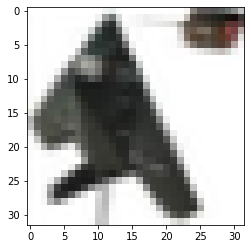

plane


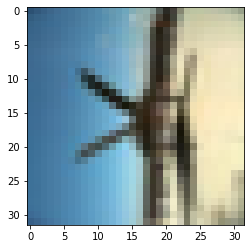

deer


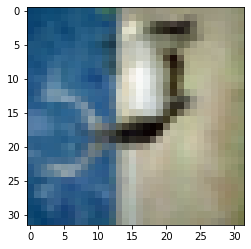

deer


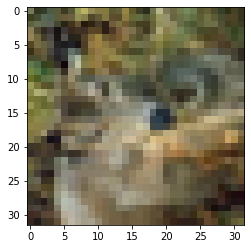

car


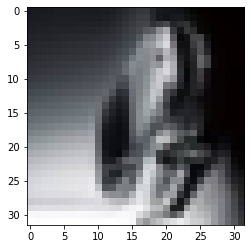

In [36]:
# Explore data
## YOUR CODE HERE ##
explore = torchvision.datasets.CIFAR10(train_dir, 
                                        download=True, 
                                        train=True, 
                                        transform=transforms.Compose([transforms.ToTensor()])
                                       )
explore_loader = torch.utils.data.DataLoader(explore, batch_size=64, shuffle=True)
show5(explore_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [37]:
## YOUR CODE HERE ##
#from torchinfo import summary

class CIFAR10Classifier(nn.Module):   
    def __init__(self):
        super(CIFAR10Classifier, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(3, 27, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(27),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.25),
            nn.MaxPool2d(kernel_size=3, stride=1),
            # Defining another 2D convolution layer
            nn.Conv2d(27, 18, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(18),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.25),
            nn.MaxPool2d(kernel_size=3, stride=1),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(10368, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.25),
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.25),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.25),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.25),
            nn.Linear(64, 10)
        )
    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        x = F.log_softmax(x, dim=1)
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [38]:
## YOUR CODE HERE ##
model = CIFAR10Classifier()
#print(summary(model))
#print(model.fc2.size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print(model)

CIFAR10Classifier(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 27, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(27, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(27, 18, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.25, inplace=False)
    (9): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=10368, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=1024, out_features=256, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_feat

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [39]:
## YOUR CODE HERE ##
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Using device: {device}")
epochs = 50
train_losses, test_losses = [], []
stop_early = False

for e in range(epochs):
    # === Run training pass ====
    running_loss = 0
    train_accuracy = 0.0
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor))
    # === Run testing pass =====
    else:
        test_loss = 0.0
        test_accuracy = 0.0
        with torch.no_grad():
            model.eval() # Turn off dropouts
            for images, labels in test_dataloader:
                images = images.to(device)
                labels = labels.to(device)
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                test_accuracy += torch.mean(equals.type(torch.FloatTensor))
        train_losses.append(running_loss)
        test_losses.append(test_loss)
        print("Epoch: {}/{}: ".format(e+1, epochs),
              "Training Loss: {:.3f} ".format(running_loss/len(train_dataloader)),
              "Training Accuracy: {:.3f}\t".format(train_accuracy/len(train_dataloader)),
              "Test Loss: {:.3f}".format(test_loss/len(test_dataloader)),
              "Test Accuracy: {:.3f}".format(test_accuracy/len(test_dataloader)))
    
    if e>=10:
        i = -5
        current_train_losses = train_losses[i:]
        current_test_losses = test_losses[i:]
        TRAINS = [1 if prev > current else 0 for prev, current in zip(current_train_losses, current_train_losses[1:])]
        TESTS = [1 if prev > current else 0 for prev, current in zip(current_test_losses, current_test_losses[1:])]

        if sum(TRAINS)<3 or sum(TESTS)<3:
            print("Increasing loss, stopping training early")
            break
    

Using device: cuda
Epoch: 1/50:  Training Loss: 2.006  Training Accuracy: 0.250	 Test Loss: 1.764 Test Accuracy: 0.343
Epoch: 2/50:  Training Loss: 1.707  Training Accuracy: 0.380	 Test Loss: 1.441 Test Accuracy: 0.474
Epoch: 3/50:  Training Loss: 1.589  Training Accuracy: 0.425	 Test Loss: 1.352 Test Accuracy: 0.515
Epoch: 4/50:  Training Loss: 1.511  Training Accuracy: 0.457	 Test Loss: 1.371 Test Accuracy: 0.503
Epoch: 5/50:  Training Loss: 1.460  Training Accuracy: 0.477	 Test Loss: 1.268 Test Accuracy: 0.542
Epoch: 6/50:  Training Loss: 1.403  Training Accuracy: 0.500	 Test Loss: 1.278 Test Accuracy: 0.537
Epoch: 7/50:  Training Loss: 1.373  Training Accuracy: 0.507	 Test Loss: 1.221 Test Accuracy: 0.559
Epoch: 8/50:  Training Loss: 1.338  Training Accuracy: 0.523	 Test Loss: 1.198 Test Accuracy: 0.563
Epoch: 9/50:  Training Loss: 1.316  Training Accuracy: 0.532	 Test Loss: 1.153 Test Accuracy: 0.585
Epoch: 10/50:  Training Loss: 1.281  Training Accuracy: 0.545	 Test Loss: 1.140 T

Plot the training loss (and validation loss/accuracy, if recorded).

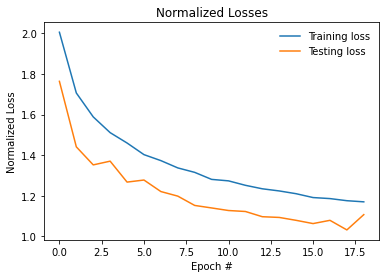

In [40]:
## YOUR CODE HERE ##
plt.plot([n/len(train_dataloader) for n in train_losses], label='Training loss')
plt.plot(torch.Tensor(test_losses).cpu() / len(test_dataloader), label='Testing loss')
plt.legend(frameon=False)
plt.title('Normalized Losses')
plt.ylabel('Normalized Loss')
plt.xlabel('Epoch #')
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [ ]:
## YOUR CODE HERE ##
train_loss = 0.0
train_accuracy = 0.0
with torch.no_grad():
    model.eval()
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        log_ps = model(images)
        train_loss += criterion(log_ps, labels)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor))

print("Train accuracy: {:.3f}%".format(100 * train_accuracy/len(train_dataloader)))

test_loss = 0.0
test_accuracy = 0.0
with torch.no_grad():
    model.eval() # Turn off dropouts
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        test_accuracy += torch.mean(equals.type(torch.FloatTensor))

print("Test accuracy: {:.3f}%".format(100 * test_accuracy/len(test_dataloader)))

## Saving your model
Using `torch.save`, save your model for future loading.

In [ ]:
## YOUR CODE HERE ##
torch.save(model.state_dict(), 'CIFAR10_Classifier.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

I do not recommend purchasing the solution from Detectocorp. Using a fairly simple convolutional neural network with two convolution layers and only using the `ToTensor()` transform, I was able to train an AI that exceeds their capabilities (71% accuracy) on the testing set for CIFAR-10 and exceeds it (82.8% accuracy) on the training set. Including augmention, I was able to achieve 57.605% on the training set and 60.45% accuracy on the testing set. Based on these results, Detectocorp is either using a simple model such as this with an un-augmented dataset that memorizes the dataset pretty well, or using a well something similar to what is present in older literature. I do not recommend purchasing their model as some additional review of the literature should be sufficient for the internal team to develop a model that easily exceeds Detectocorp's model.